In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader_pw import *
from cnn_model_1 import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'pairwise_lstm.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = PWDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

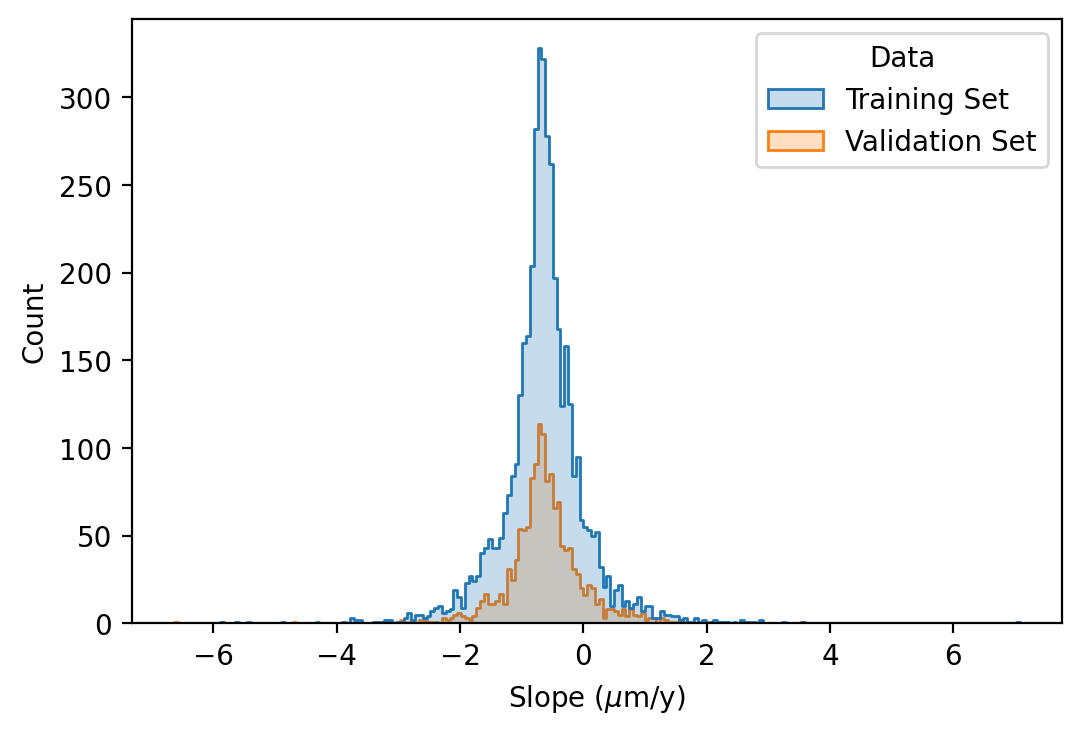

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

4445 1482


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

2


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'pw_statedict.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.38, running_loss=33.2]


Train Loss: 33.1614 | Valid Loss: inf ===========> 10.6527 | Test Loss: 10.6358 | Saving model...


Epoch [2/200]: 100%|██████████| 70/70 [00:09<00:00,  7.74it/s, batch_loss=0.407, running_loss=31.7]


Train Loss: 31.7467 | Valid Loss: 10.6527 ===========> 9.9199 | Test Loss: 10.1767 | Saving model...


Epoch [3/200]: 100%|██████████| 70/70 [00:09<00:00,  7.47it/s, batch_loss=0.263, running_loss=30.4]


Train Loss: 30.3930 | Valid Loss: 10.4525


Epoch [4/200]: 100%|██████████| 70/70 [00:09<00:00,  7.33it/s, batch_loss=0.26, running_loss=29]


Train Loss: 29.0175 | Valid Loss: 9.9199 ===========> 9.3575 | Test Loss: 9.8435 | Saving model...


Epoch [5/200]: 100%|██████████| 70/70 [00:09<00:00,  7.34it/s, batch_loss=0.686, running_loss=28.3]


Train Loss: 28.2596 | Valid Loss: 11.1481


Epoch [6/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.219, running_loss=26.5]


Train Loss: 26.5066 | Valid Loss: 9.3575 ===========> 8.5954 | Test Loss: 8.9380 | Saving model...


Epoch [7/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.313, running_loss=24.3]


Train Loss: 24.3117 | Valid Loss: 8.5954 ===========> 8.5261 | Test Loss: 8.9266 | Saving model...


Epoch [8/200]: 100%|██████████| 70/70 [00:09<00:00,  7.42it/s, batch_loss=0.164, running_loss=23.2]


Train Loss: 23.2248 | Valid Loss: 8.5261 ===========> 8.4414 | Test Loss: 8.8965 | Saving model...


Epoch [9/200]: 100%|██████████| 70/70 [00:09<00:00,  7.30it/s, batch_loss=0.7, running_loss=20.8]


Train Loss: 20.7986 | Valid Loss: 9.7273


Epoch [10/200]: 100%|██████████| 70/70 [00:09<00:00,  7.52it/s, batch_loss=0.318, running_loss=19.1]


Train Loss: 19.0758 | Valid Loss: 8.4414 ===========> 7.6587 | Test Loss: 7.7401 | Saving model...


Epoch [11/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.214, running_loss=18.1]


Train Loss: 18.1342 | Valid Loss: 9.4931


Epoch [12/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.411, running_loss=17.6]


Train Loss: 17.5538 | Valid Loss: 8.8625


Epoch [13/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.14, running_loss=15.9]


Train Loss: 15.8823 | Valid Loss: 7.6587 ===========> 6.6905 | Test Loss: 6.9902 | Saving model...


Epoch [14/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.413, running_loss=15.5]


Train Loss: 15.5281 | Valid Loss: 10.0231


Epoch [15/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.284, running_loss=15]


Train Loss: 14.9695 | Valid Loss: 9.6071


Epoch [16/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.154, running_loss=14.4]


Train Loss: 14.4074 | Valid Loss: 6.8121


Epoch [17/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.135, running_loss=13.1]


Train Loss: 13.1399 | Valid Loss: 7.1047


Epoch [18/200]: 100%|██████████| 70/70 [00:09<00:00,  7.59it/s, batch_loss=0.184, running_loss=12.3]


Train Loss: 12.3336 | Valid Loss: 6.9752


Epoch [19/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.135, running_loss=12.9]


Train Loss: 12.9305 | Valid Loss: 6.6905 ===========> 6.1121 | Test Loss: 6.8595 | Saving model...


Epoch [20/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.07, running_loss=11.4]


Train Loss: 11.4119 | Valid Loss: 6.5198


Epoch [21/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0786, running_loss=11.4]


Train Loss: 11.3916 | Valid Loss: 6.4342


Epoch [22/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0693, running_loss=10.9]


Train Loss: 10.8751 | Valid Loss: 6.3240


Epoch [23/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.134, running_loss=10.2]


Train Loss: 10.2167 | Valid Loss: 6.7480


Epoch [24/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0791, running_loss=10]


Train Loss: 10.0348 | Valid Loss: 6.4778


Epoch [25/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.13, running_loss=9.17]


Train Loss: 9.1747 | Valid Loss: 6.4141


Epoch [26/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0995, running_loss=9.04]


Train Loss: 9.0378 | Valid Loss: 7.6115


Epoch [27/200]: 100%|██████████| 70/70 [00:09<00:00,  7.58it/s, batch_loss=0.168, running_loss=8.56]


Train Loss: 8.5593 | Valid Loss: 7.5856


Epoch [28/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.159, running_loss=7.93]


Train Loss: 7.9324 | Valid Loss: 7.0175


Epoch [29/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0759, running_loss=8.01]


Train Loss: 8.0097 | Valid Loss: 6.1121 ===========> 5.7850 | Test Loss: 6.9669 | Saving model...


Epoch [30/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.061, running_loss=7.17]


Train Loss: 7.1651 | Valid Loss: 5.7850 ===========> 5.6646 | Test Loss: 6.0245 | Saving model...


Epoch [31/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0756, running_loss=6.85]


Train Loss: 6.8456 | Valid Loss: 5.7538


Epoch [32/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0811, running_loss=6.58]


Train Loss: 6.5779 | Valid Loss: 5.7055


Epoch [33/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0932, running_loss=6.11]


Train Loss: 6.1116 | Valid Loss: 5.6678


Epoch [34/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.109, running_loss=5.82]


Train Loss: 5.8196 | Valid Loss: 5.8591


Epoch [35/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.121, running_loss=5.65]


Train Loss: 5.6473 | Valid Loss: 5.7322


Epoch [36/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0746, running_loss=5.26]


Train Loss: 5.2582 | Valid Loss: 5.7152


Epoch [37/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.0545, running_loss=4.86]


Train Loss: 4.8637 | Valid Loss: 5.6646 ===========> 5.6171 | Test Loss: 6.2120 | Saving model...


Epoch [38/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.119, running_loss=4.66]


Train Loss: 4.6596 | Valid Loss: 6.3355


Epoch [39/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.105, running_loss=4.3]


Train Loss: 4.3037 | Valid Loss: 5.8636


Epoch [40/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.038, running_loss=4.27]


Train Loss: 4.2684 | Valid Loss: 5.6171 ===========> 5.4853 | Test Loss: 6.2095 | Saving model...


Epoch [41/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0609, running_loss=4.13]


Train Loss: 4.1320 | Valid Loss: 5.5304


Epoch [42/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0428, running_loss=3.74]


Train Loss: 3.7378 | Valid Loss: 5.4853 ===========> 5.3074 | Test Loss: 5.9472 | Saving model...


Epoch [43/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0552, running_loss=3.6]


Train Loss: 3.5957 | Valid Loss: 5.5571


Epoch [44/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0606, running_loss=3.56]


Train Loss: 3.5577 | Valid Loss: 5.4485


Epoch [45/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0576, running_loss=3.61]


Train Loss: 3.6072 | Valid Loss: 5.5478


Epoch [46/200]: 100%|██████████| 70/70 [00:09<00:00,  7.68it/s, batch_loss=0.192, running_loss=3.41]


Train Loss: 3.4078 | Valid Loss: 5.6943


Epoch [47/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0522, running_loss=3.51]


Train Loss: 3.5110 | Valid Loss: 5.9650


Epoch [48/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.117, running_loss=3.29]


Train Loss: 3.2859 | Valid Loss: 5.6878


Epoch [49/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0468, running_loss=3.06]


Train Loss: 3.0592 | Valid Loss: 5.4815


Epoch [50/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0346, running_loss=2.95]


Train Loss: 2.9453 | Valid Loss: 5.8081


Epoch [51/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0417, running_loss=2.91]


Train Loss: 2.9107 | Valid Loss: 5.6389


Epoch [52/200]: 100%|██████████| 70/70 [00:09<00:00,  7.67it/s, batch_loss=0.0749, running_loss=2.99]


Train Loss: 2.9928 | Valid Loss: 5.6680


Epoch [53/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0329, running_loss=2.96]


Train Loss: 2.9574 | Valid Loss: 5.8744


Epoch [54/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0617, running_loss=2.85]


Train Loss: 2.8542 | Valid Loss: 6.4937


Epoch [55/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0482, running_loss=2.7]


Train Loss: 2.6991 | Valid Loss: 5.5297


Epoch [56/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.025, running_loss=2.65]


Train Loss: 2.6513 | Valid Loss: 5.4544


Epoch [57/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0204, running_loss=2.65]


Train Loss: 2.6514 | Valid Loss: 5.6812


Epoch [58/200]: 100%|██████████| 70/70 [00:09<00:00,  7.54it/s, batch_loss=0.0235, running_loss=2.6]


Train Loss: 2.6049 | Valid Loss: 5.4716


Epoch [59/200]: 100%|██████████| 70/70 [00:09<00:00,  7.53it/s, batch_loss=0.0193, running_loss=2.42]


Train Loss: 2.4150 | Valid Loss: 5.5438


Epoch [60/200]: 100%|██████████| 70/70 [00:09<00:00,  7.53it/s, batch_loss=0.0281, running_loss=2.52]


Train Loss: 2.5163 | Valid Loss: 5.5007


Epoch [61/200]: 100%|██████████| 70/70 [00:09<00:00,  7.53it/s, batch_loss=0.0265, running_loss=2.47]


Train Loss: 2.4727 | Valid Loss: 5.6479


Epoch [62/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0401, running_loss=2.48]


Train Loss: 2.4751 | Valid Loss: 5.6403


Epoch [63/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0234, running_loss=2.4]


Train Loss: 2.3965 | Valid Loss: 5.5348


Epoch [64/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0239, running_loss=2.25]


Train Loss: 2.2473 | Valid Loss: 5.5777


Epoch [65/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0286, running_loss=2.19]


Train Loss: 2.1899 | Valid Loss: 5.6422


Epoch [66/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0435, running_loss=2.29]


Train Loss: 2.2902 | Valid Loss: 5.8369


Epoch [67/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0349, running_loss=2.25]


Train Loss: 2.2524 | Valid Loss: 5.6400


Epoch [68/200]: 100%|██████████| 70/70 [00:09<00:00,  7.61it/s, batch_loss=0.0354, running_loss=2.25]


Train Loss: 2.2475 | Valid Loss: 5.7245


Epoch [69/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0218, running_loss=2.18]


Train Loss: 2.1810 | Valid Loss: 5.7425


Epoch [70/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.0646, running_loss=2.33]


Train Loss: 2.3307 | Valid Loss: 5.6391


Epoch [71/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0195, running_loss=2.03]


Train Loss: 2.0347 | Valid Loss: 5.7200


Epoch [72/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0131, running_loss=2.1]


Train Loss: 2.1027 | Valid Loss: 6.0353


Epoch [73/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0465, running_loss=2.2]


Train Loss: 2.2029 | Valid Loss: 5.7498


Epoch [74/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.0279, running_loss=2.02]


Train Loss: 2.0187 | Valid Loss: 5.7757


Epoch [75/200]: 100%|██████████| 70/70 [00:09<00:00,  7.65it/s, batch_loss=0.0276, running_loss=2.08]


Train Loss: 2.0791 | Valid Loss: 5.5207


Epoch [76/200]: 100%|██████████| 70/70 [00:09<00:00,  7.60it/s, batch_loss=0.0342, running_loss=1.97]


Train Loss: 1.9711 | Valid Loss: 5.5885


Epoch [77/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0373, running_loss=2.09]


Train Loss: 2.0864 | Valid Loss: 5.6205


Epoch [78/200]: 100%|██████████| 70/70 [00:09<00:00,  7.64it/s, batch_loss=0.0311, running_loss=2]


Train Loss: 1.9957 | Valid Loss: 5.7409


Epoch [79/200]: 100%|██████████| 70/70 [00:09<00:00,  7.62it/s, batch_loss=0.00837, running_loss=2.02]


Train Loss: 2.0167 | Valid Loss: 5.9026


Epoch [80/200]: 100%|██████████| 70/70 [00:09<00:00,  7.63it/s, batch_loss=0.0309, running_loss=1.94]


Train Loss: 1.9438 | Valid Loss: 5.8349


Epoch [81/200]: 100%|██████████| 70/70 [00:09<00:00,  7.66it/s, batch_loss=0.016, running_loss=1.91]


Train Loss: 1.9116 | Valid Loss: 5.6757


Epoch [82/200]: 100%|██████████| 70/70 [00:09<00:00,  7.44it/s, batch_loss=0.0182, running_loss=1.86]


Train Loss: 1.8620 | Valid Loss: 5.7132


Epoch [83/200]: 100%|██████████| 70/70 [00:09<00:00,  7.45it/s, batch_loss=0.0234, running_loss=1.95]


Train Loss: 1.9471 | Valid Loss: 6.0149


Epoch [84/200]: 100%|██████████| 70/70 [00:09<00:00,  7.57it/s, batch_loss=0.0191, running_loss=1.85]


Train Loss: 1.8485 | Valid Loss: 5.5892


Epoch [85/200]: 100%|██████████| 70/70 [00:09<00:00,  7.43it/s, batch_loss=0.0199, running_loss=1.97]


Train Loss: 1.9706 | Valid Loss: 5.6117


Epoch [86/200]: 100%|██████████| 70/70 [00:08<00:00,  7.84it/s, batch_loss=0.0189, running_loss=1.84]


Train Loss: 1.8361 | Valid Loss: 5.5510


Epoch [87/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0274, running_loss=1.92]


Train Loss: 1.9248 | Valid Loss: 5.5239


Epoch [88/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0181, running_loss=1.83]


Train Loss: 1.8281 | Valid Loss: 6.0135


Epoch [89/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.00899, running_loss=1.86]


Train Loss: 1.8551 | Valid Loss: 5.6410


Epoch [90/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0163, running_loss=1.83]


Train Loss: 1.8278 | Valid Loss: 5.6725


Epoch [91/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0132, running_loss=1.81]


Train Loss: 1.8105 | Valid Loss: 6.4315


Epoch [92/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0176, running_loss=1.83]


Train Loss: 1.8335 | Valid Loss: 6.0051


Epoch [93/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0352, running_loss=1.82]


Train Loss: 1.8212 | Valid Loss: 5.4280


Epoch [94/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0858, running_loss=1.81]


Train Loss: 1.8112 | Valid Loss: 5.5987


Epoch [95/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0213, running_loss=1.78]


Train Loss: 1.7807 | Valid Loss: 5.5270


Epoch [96/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0173, running_loss=1.86]


Train Loss: 1.8568 | Valid Loss: 5.5577


Epoch [97/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0236, running_loss=1.8]


Train Loss: 1.8024 | Valid Loss: 5.8543


Epoch [98/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0213, running_loss=1.78]


Train Loss: 1.7843 | Valid Loss: 5.9380


Epoch [99/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0411, running_loss=1.78]


Train Loss: 1.7833 | Valid Loss: 6.2301


Epoch [100/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.023, running_loss=1.85]


Train Loss: 1.8517 | Valid Loss: 5.5057


Epoch [101/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0119, running_loss=1.83]


Train Loss: 1.8263 | Valid Loss: 5.6884


Epoch [102/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0211, running_loss=1.71]


Train Loss: 1.7097 | Valid Loss: 5.5973


Epoch [103/200]: 100%|██████████| 70/70 [00:08<00:00,  7.89it/s, batch_loss=0.0104, running_loss=1.7]


Train Loss: 1.6952 | Valid Loss: 5.7385


Epoch [104/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0109, running_loss=1.71]


Train Loss: 1.7071 | Valid Loss: 5.5945


Epoch [105/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0201, running_loss=1.73]


Train Loss: 1.7284 | Valid Loss: 5.6740


Epoch [106/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0119, running_loss=1.62]


Train Loss: 1.6212 | Valid Loss: 5.7608


Epoch [107/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0298, running_loss=1.66]


Train Loss: 1.6649 | Valid Loss: 5.7963


Epoch [108/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0185, running_loss=1.62]


Train Loss: 1.6215 | Valid Loss: 5.6346


Epoch [109/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0136, running_loss=1.7]


Train Loss: 1.6958 | Valid Loss: 5.6112


Epoch [110/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0155, running_loss=1.74]


Train Loss: 1.7381 | Valid Loss: 5.7249


Epoch [111/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0696, running_loss=1.78]


Train Loss: 1.7815 | Valid Loss: 6.1538


Epoch [112/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0156, running_loss=1.72]


Train Loss: 1.7209 | Valid Loss: 5.6257


Epoch [113/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0203, running_loss=1.6]


Train Loss: 1.6011 | Valid Loss: 6.1659


Epoch [114/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0804, running_loss=1.72]


Train Loss: 1.7159 | Valid Loss: 5.8575


Epoch [115/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0164, running_loss=1.59]


Train Loss: 1.5917 | Valid Loss: 5.6891


Epoch [116/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0189, running_loss=1.59]


Train Loss: 1.5926 | Valid Loss: 5.4893


Epoch [117/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.048, running_loss=1.67]


Train Loss: 1.6722 | Valid Loss: 5.5417


Epoch [118/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0144, running_loss=1.59]


Train Loss: 1.5904 | Valid Loss: 6.3664


Epoch [119/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0162, running_loss=1.64]


Train Loss: 1.6407 | Valid Loss: 5.6257


Epoch [120/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.0119, running_loss=1.63]


Train Loss: 1.6321 | Valid Loss: 5.5599


Epoch [121/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0945, running_loss=1.44]


Train Loss: 1.4408 | Valid Loss: 5.5707


Epoch [122/200]: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, batch_loss=0.016, running_loss=1.42]


Train Loss: 1.4229 | Valid Loss: 5.9682


Epoch [123/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0177, running_loss=1.4]


Train Loss: 1.4048 | Valid Loss: 5.6746


Epoch [124/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0196, running_loss=1.37]


Train Loss: 1.3666 | Valid Loss: 5.6704


Epoch [125/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.00969, running_loss=1.4]


Train Loss: 1.3954 | Valid Loss: 5.6018


Epoch [126/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.026, running_loss=1.4]


Train Loss: 1.4012 | Valid Loss: 5.5569


Epoch [127/200]: 100%|██████████| 70/70 [00:08<00:00,  7.99it/s, batch_loss=0.0149, running_loss=1.38]


Train Loss: 1.3769 | Valid Loss: 5.5157


Epoch [128/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0164, running_loss=1.35]


Train Loss: 1.3466 | Valid Loss: 5.5170


Epoch [129/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.013, running_loss=1.35]


Train Loss: 1.3526 | Valid Loss: 5.5826


Epoch [130/200]: 100%|██████████| 70/70 [00:08<00:00,  7.98it/s, batch_loss=0.0134, running_loss=1.36]


Train Loss: 1.3569 | Valid Loss: 5.5814


Epoch [131/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.017, running_loss=1.34]


Train Loss: 1.3381 | Valid Loss: 5.6231


Epoch [132/200]: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, batch_loss=0.0783, running_loss=1.37]


Train Loss: 1.3739 | Valid Loss: 5.6328


Epoch [133/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0225, running_loss=1.39]


Train Loss: 1.3933 | Valid Loss: 5.6281


Epoch [134/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.0129, running_loss=1.33]


Train Loss: 1.3266 | Valid Loss: 5.5474


Epoch [135/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0461, running_loss=1.38]


Train Loss: 1.3793 | Valid Loss: 5.8352


Epoch [136/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.00944, running_loss=1.35]


Train Loss: 1.3480 | Valid Loss: 5.6693


Epoch [137/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0139, running_loss=1.36]


Train Loss: 1.3624 | Valid Loss: 5.7160


Epoch [138/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0144, running_loss=1.35]


Train Loss: 1.3533 | Valid Loss: 5.6502


Epoch [139/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0323, running_loss=1.38]


Train Loss: 1.3760 | Valid Loss: 5.5529


Epoch [140/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0257, running_loss=1.37]


Train Loss: 1.3667 | Valid Loss: 5.6615


Epoch [141/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0319, running_loss=1.37]


Train Loss: 1.3672 | Valid Loss: 5.7623


Epoch [142/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.00855, running_loss=1.35]


Train Loss: 1.3481 | Valid Loss: 5.5636


Epoch [143/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.0123, running_loss=1.35]


Train Loss: 1.3517 | Valid Loss: 5.7474


Epoch [144/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0286, running_loss=1.34]


Train Loss: 1.3378 | Valid Loss: 5.8959


Epoch [145/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0102, running_loss=1.37]


Train Loss: 1.3653 | Valid Loss: 5.5672


Epoch [146/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0109, running_loss=1.38]


Train Loss: 1.3802 | Valid Loss: 5.7729


Epoch [147/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0139, running_loss=1.38]


Train Loss: 1.3773 | Valid Loss: 5.6498


Epoch [148/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.0126, running_loss=1.34]


Train Loss: 1.3368 | Valid Loss: 5.6492


Epoch [149/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0176, running_loss=1.36]


Train Loss: 1.3617 | Valid Loss: 5.6907


Epoch [150/200]: 100%|██████████| 70/70 [00:08<00:00,  7.98it/s, batch_loss=0.0267, running_loss=1.34]


Train Loss: 1.3358 | Valid Loss: 5.6280


Epoch [151/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.00841, running_loss=1.4]


Train Loss: 1.4030 | Valid Loss: 5.5431


Epoch [152/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.00786, running_loss=1.31]


Train Loss: 1.3116 | Valid Loss: 5.9006


Epoch [153/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0927, running_loss=1.37]


Train Loss: 1.3665 | Valid Loss: 5.5373


Epoch [154/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0196, running_loss=1.3]


Train Loss: 1.3030 | Valid Loss: 5.8020


Epoch [155/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0123, running_loss=1.35]


Train Loss: 1.3507 | Valid Loss: 5.6457


Epoch [156/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0105, running_loss=1.36]


Train Loss: 1.3604 | Valid Loss: 6.6382


Epoch [157/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.065, running_loss=1.38]


Train Loss: 1.3766 | Valid Loss: 5.5537


Epoch [158/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0374, running_loss=1.35]


Train Loss: 1.3473 | Valid Loss: 5.5683


Epoch [159/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0123, running_loss=1.32]


Train Loss: 1.3213 | Valid Loss: 5.5684


Epoch [160/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.0147, running_loss=1.3]


Train Loss: 1.2983 | Valid Loss: 5.6765


Epoch [161/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0183, running_loss=1.36]


Train Loss: 1.3573 | Valid Loss: 5.7036


Epoch [162/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0209, running_loss=1.34]


Train Loss: 1.3385 | Valid Loss: 6.2729


Epoch [163/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0244, running_loss=1.34]


Train Loss: 1.3398 | Valid Loss: 5.6359


Epoch [164/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.023, running_loss=1.37]


Train Loss: 1.3685 | Valid Loss: 5.6368


Epoch [165/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0272, running_loss=1.38]


Train Loss: 1.3829 | Valid Loss: 5.7281


Epoch [166/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.00935, running_loss=1.36]


Train Loss: 1.3621 | Valid Loss: 5.5323


Epoch [167/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0374, running_loss=1.36]


Train Loss: 1.3602 | Valid Loss: 5.5885


Epoch [168/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.016, running_loss=1.34]


Train Loss: 1.3373 | Valid Loss: 5.5199


Epoch [169/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0238, running_loss=1.37]


Train Loss: 1.3692 | Valid Loss: 5.5277


Epoch [170/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.0319, running_loss=1.32]


Train Loss: 1.3161 | Valid Loss: 5.5858


Epoch [171/200]: 100%|██████████| 70/70 [00:08<00:00,  7.90it/s, batch_loss=0.0135, running_loss=1.33]


Train Loss: 1.3265 | Valid Loss: 5.6600


Epoch [172/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.0235, running_loss=1.35]


Train Loss: 1.3518 | Valid Loss: 7.3845


Epoch [173/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0701, running_loss=1.36]


Train Loss: 1.3589 | Valid Loss: 7.4100


Epoch [174/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0907, running_loss=1.34]


Train Loss: 1.3382 | Valid Loss: 5.6442


Epoch [175/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0159, running_loss=1.35]


Train Loss: 1.3535 | Valid Loss: 5.6670


Epoch [176/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.045, running_loss=1.34]


Train Loss: 1.3396 | Valid Loss: 5.7062


Epoch [177/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0227, running_loss=1.35]


Train Loss: 1.3541 | Valid Loss: 5.7014


Epoch [178/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0111, running_loss=1.33]


Train Loss: 1.3271 | Valid Loss: 5.5636


Epoch [179/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0114, running_loss=1.32]


Train Loss: 1.3243 | Valid Loss: 5.7157


Epoch [180/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0195, running_loss=1.36]


Train Loss: 1.3606 | Valid Loss: 5.6682


Epoch [181/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0427, running_loss=1.37]


Train Loss: 1.3679 | Valid Loss: 5.5480


Epoch [182/200]: 100%|██████████| 70/70 [00:08<00:00,  7.91it/s, batch_loss=0.0179, running_loss=1.35]


Train Loss: 1.3533 | Valid Loss: 6.0594


Epoch [183/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0292, running_loss=1.36]


Train Loss: 1.3607 | Valid Loss: 5.6114


Epoch [184/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0497, running_loss=1.29]


Train Loss: 1.2881 | Valid Loss: 5.5511


Epoch [185/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0115, running_loss=1.3]


Train Loss: 1.3049 | Valid Loss: 5.6156


Epoch [186/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.00687, running_loss=1.35]


Train Loss: 1.3498 | Valid Loss: 5.6114


Epoch [187/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.00766, running_loss=1.31]


Train Loss: 1.3129 | Valid Loss: 5.7204


Epoch [188/200]: 100%|██████████| 70/70 [00:08<00:00,  7.93it/s, batch_loss=0.0101, running_loss=1.38]


Train Loss: 1.3773 | Valid Loss: 6.4031


Epoch [189/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0435, running_loss=1.35]


Train Loss: 1.3500 | Valid Loss: 5.6449


Epoch [190/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0425, running_loss=1.31]


Train Loss: 1.3135 | Valid Loss: 5.7536


Epoch [191/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.00925, running_loss=1.36]


Train Loss: 1.3591 | Valid Loss: 5.5762


Epoch [192/200]: 100%|██████████| 70/70 [00:08<00:00,  7.88it/s, batch_loss=0.00895, running_loss=1.35]


Train Loss: 1.3540 | Valid Loss: 5.6737


Epoch [193/200]: 100%|██████████| 70/70 [00:08<00:00,  7.94it/s, batch_loss=0.0178, running_loss=1.3]


Train Loss: 1.2989 | Valid Loss: 5.5732


Epoch [194/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.017, running_loss=1.33]


Train Loss: 1.3308 | Valid Loss: 5.5916


Epoch [195/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.0425, running_loss=1.33]


Train Loss: 1.3297 | Valid Loss: 5.5990


Epoch [196/200]: 100%|██████████| 70/70 [00:08<00:00,  7.97it/s, batch_loss=0.0122, running_loss=1.33]


Train Loss: 1.3308 | Valid Loss: 5.6774


Epoch [197/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.00985, running_loss=1.31]


Train Loss: 1.3139 | Valid Loss: 5.7160


Epoch [198/200]: 100%|██████████| 70/70 [00:08<00:00,  7.92it/s, batch_loss=0.012, running_loss=1.33]


Train Loss: 1.3330 | Valid Loss: 5.6224


Epoch [199/200]: 100%|██████████| 70/70 [00:08<00:00,  7.95it/s, batch_loss=0.0107, running_loss=1.33]


Train Loss: 1.3343 | Valid Loss: 5.5998


Epoch [200/200]: 100%|██████████| 70/70 [00:08<00:00,  7.96it/s, batch_loss=0.0126, running_loss=1.29]


Train Loss: 1.2944 | Valid Loss: 5.6169


Train Loss: 3.7378 | Valid Loss: 5.3074 | Test Loss on Best Model: 5.9472


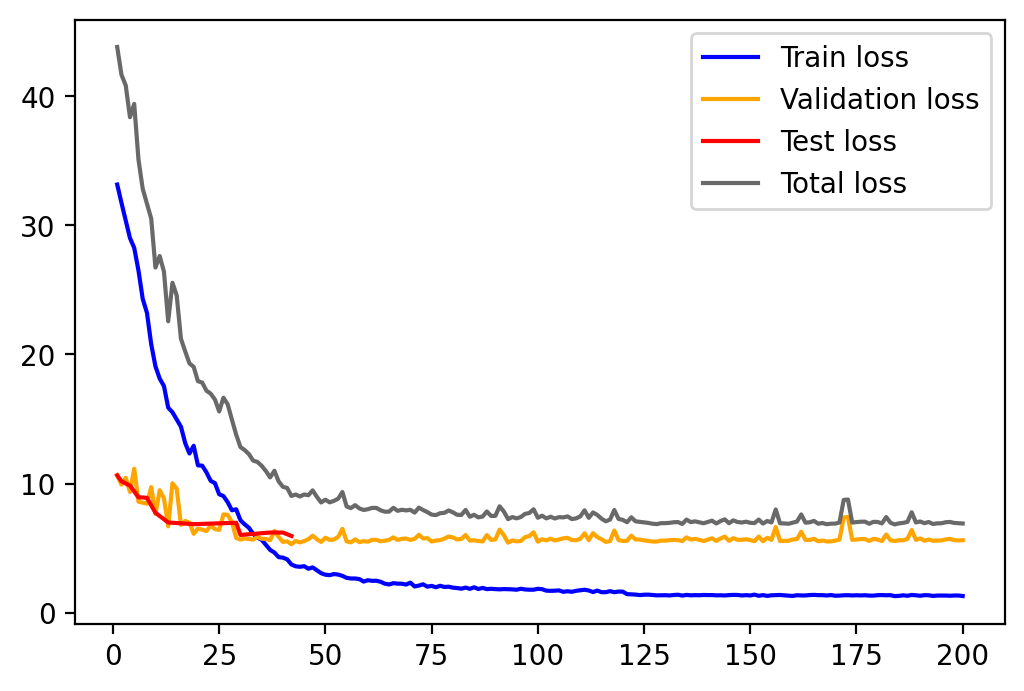

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [9]:
tsloss = 0
model.load_state_dict(torch.load('pw_statedict.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


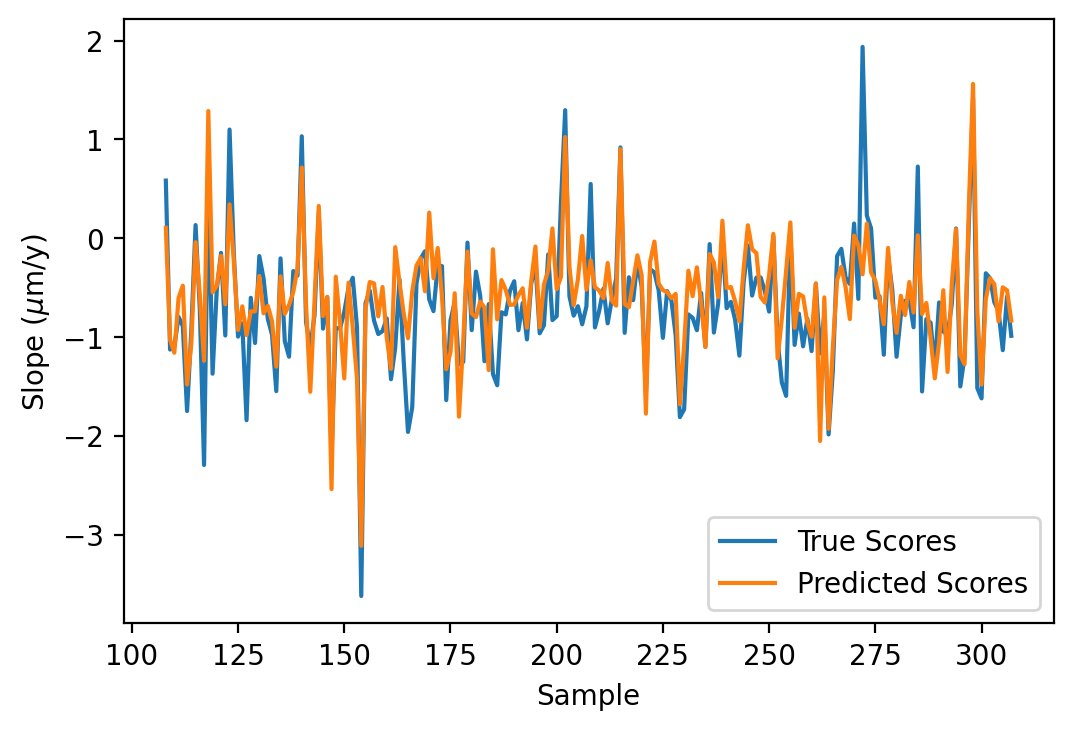

In [10]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

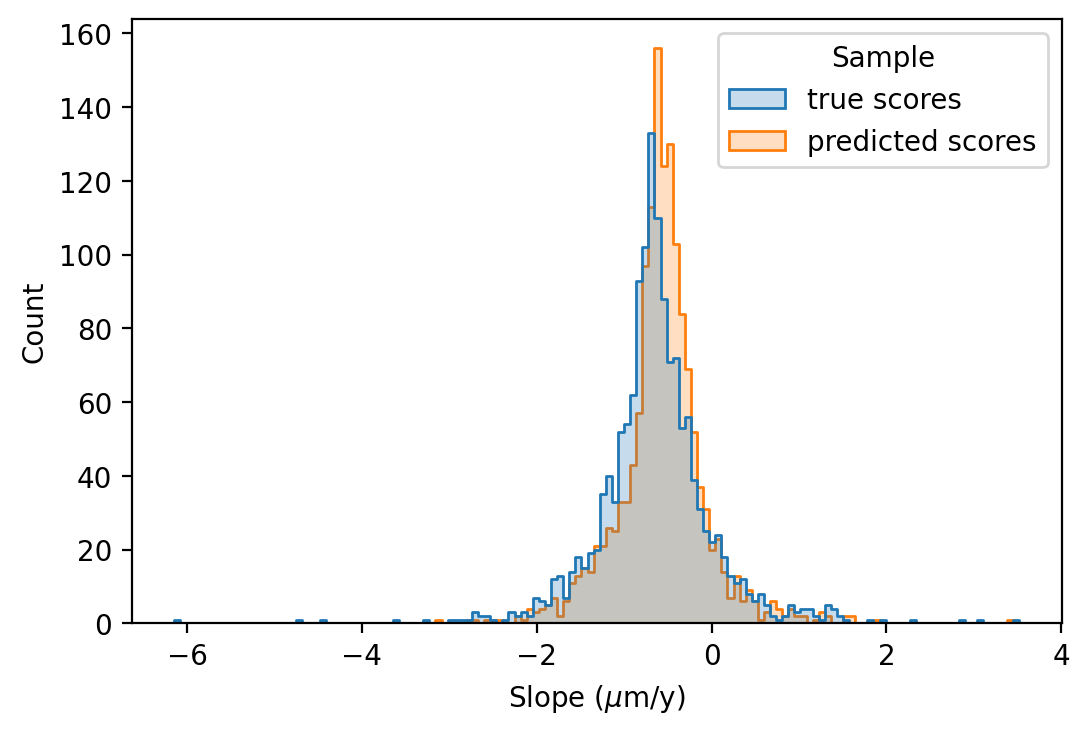

In [11]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [12]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.14709851551956815, pvalue=2.130035830213446e-14)


In [13]:
df.to_csv('predscores.csv')

In [14]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

In [15]:
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv('predscores.csv')

In [17]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [18]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [19]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [20]:
coefficient_of_dermination

0.43269723397599347

In [37]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [38]:
rsquared(true, pred)

0.4623647597482398

In [39]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6554435360208855, pvalue=1.1725875018713395e-182)

In [40]:
scipy.stats.pearsonr(true, pred)

(0.67997408755646, 1.1087197917211379e-201)